In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#model_path = '/content/drive/MyDrive/DL_project/Electra/trained_model_electra_new_para_data'
model_path = '/content/drive/MyDrive/DL_project/Roberta/roberta_1_fine_tuned_model'


In [3]:
import os
#print(os.path.exists('/content/drive/MyDrive/DL_project/Electra/trained_model_electra_new_para_data'))  # Should print True if the folder exists
print(os.path.exists('/content/drive/MyDrive/DL_project/Roberta/roberta_1_fine_tuned_model'))  # Should print True if the folder exists


True


In [4]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

In [ ]:
!pip install tokenizer datasets

**Least to Most**

In [7]:
import torch
# Sample text to analyze
text = """

Self Consistency (COT) Goal: The Self Consistency technique is used to enhance the forecast accuracy and dependability of the model. In this method, various outputs are generated for the same input, and the most consistent response among all the created answers is used to determine the final output.
Application: Several outputs are generated for each query in each model, and the most reliable answer is chosen. This method produces more trustworthy outcomes by reducing biases and inconsistencies in the model's predictions.
Direct Prompt Objective: When simple, straightforward responses are required, then direct prompting is used. In this approach, the model is given a very clear and concise instruction to which it is expected to provide a direct response without having to use complex logic or numerous steps.
Application: The models are directly prompted to instantiate responses for immediate answers when the task requires only simple fact retrieval or classification. In this way, the models can focus on generating responses with accuracy and speed where the task at hand does not require reasoning or elaborate instructions.


"""

prompts = [
    "Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.",  # Complex prompt with focus on markers
    "What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.",  # More in-depth feature-based analysis
    "Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.",  # Deeper into patterns and features
    "What are the primary distinctions between human-written, AI-generated, and paraphrased texts? Analyze aspects such as creativity, consistency, structure, and originality. How do these features influence the classification?",  # Detailed comparative analysis
]




In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_prediction(prompt, text):
    # Tokenize input and model prediction
    inputs = tokenizer(prompt + " " + text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()  # Convert logits to predicted class (0, 1, or 2)
    return predicted_class

#Least-to-Most prompting
for prompt in prompts:
    result = get_prediction(prompt, text)
    prediction_label = 'AI-generated' if result == 1 else 'Human-written' if result == 0 else 'Paraphrased'
    print(f"Prompt: {prompt}")
    print(f"Prediction: {prediction_label}")
    print("\n")


Prompt: Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.
Prediction: Paraphrased


Prompt: What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.
Prediction: Paraphrased


Prompt: Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.
Prediction: Human-written


Prompt: What are the primary distinctions between human-written, AI-generated, and paraphrased texts? Analyze aspects such as creativity, consistency, structure, and originality. How do these features influence the classification?
Prediction: Paraphrased




In [25]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

logits_list = []  # Initialize an empty list to collect logits
predictions = []  # Initialize an empty list to collect predictions

def get_prediction_with_threshold(prompt, text, threshold=0.5):
    # Tokenize input
    inputs = tokenizer(prompt + " " + text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits

    # Softmax to get probabilities
    probs = torch.softmax(logits, dim=-1)
    max_prob, predicted_class = torch.max(probs, dim=-1)

    # Apply thresholding
    if max_prob < threshold:
        return 2, logits
    return predicted_class.item(), logits

# Iterate through prompts and collect predictions and logits
for prompt in prompts:
    result, logits = get_prediction_with_threshold(prompt, text)
    logits_list.append(logits.squeeze(0))  # Append logits to the list (squeeze to remove batch dimension)
    predictions.append(result)  # Append the predicted class
    prediction_label = 'AI-generated' if result == 1 else 'Human-written' if result == 0 else 'Paraphrased'
    print(f"Prompt: {prompt}")
    print(f"Logits: {logits}")
    print(f"Prediction: {prediction_label}")
    print("\n")



Prompt: Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.
Logits: tensor([[-0.2379, -5.4297,  4.9026]], device='cuda:0')
Prediction: Paraphrased


Prompt: What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.
Logits: tensor([[ 1.0792, -6.1891,  4.3052]], device='cuda:0')
Prediction: Paraphrased


Prompt: Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.
Logits: tensor([[ 3.1247, -6.3492,  2.4977]], device='cuda:0')
Prediction: Human-written


Prompt: What are the primary distinctions between human-written, AI-generated, and paraphrased texts? Analyze aspects such as creativity, consistency, structure, 

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import classification_report
import pandas as pd

df_human = pd.read_csv("human.csv")
df_ai = pd.read_csv("ai.csv")
df_paraphrased = pd.read_csv("paraphrased.csv")

df_human['label'] = 0
df_ai['label'] = 1
df_paraphrased['label'] = 2

# only abstract and label columns are required
df_human = df_human[['abstract', 'label']]
df_ai = df_ai[['abstract', 'label']]
df_paraphrased = df_paraphrased[['abstract', 'label']]

#combining all csv
df = pd.concat([df_human, df_ai, df_paraphrased], ignore_index=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#to check count of each class to ensure it is balanced
print(df['label'].value_counts())

#dataset split into 80% train and 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training Set Size: {len(train_df)}")
print(f"Test Set Size: {len(test_df)}")


# Select 10 random samples from the test dataset
random_test_samples = test_df.sample(n=10, random_state=42)

# Iterate through each row in the random test samples
for idx, row in random_test_samples.iterrows():
    text = row['abstract']  # Extract the abstract (text) from the current row
    true_label = row['label']  # Extract the true label for evaluation

    print(text)
    print(f"Evaluating test example {idx + 1}/{len(random_test_samples)}")
    print(f"True Label: {true_label}")

    logits_list = []  # Collect logits for all prompts for this text
    predictions = []  # Collect predictions for all prompts for this text

    # Iterate through prompts
    for prompt in prompts:
        result, logits = get_prediction_with_threshold(prompt, text)
        logits_list.append(logits.squeeze(0))  # Append logits to the list
        predictions.append(result)  # Append the predicted class
        prediction_label = 'AI-generated' if result == 1 else 'Human-written' if result == 0 else 'Paraphrased'
        print(f"Prompt: {prompt}")
        print(f"Logits: {logits}")
        print(f"Prediction: {prediction_label}")
        print("\n")

    # Aggregate predictions for this text (if needed)
    most_common_prediction = max(set(predictions), key=predictions.count)
    print(f"Most Common Prediction for this example: {most_common_prediction}")
    print("\n" + "="*80 + "\n")


label
1    15395
2    15395
0    15391
Name: count, dtype: int64
Training Set Size: 36944
Test Set Size: 9237
This paper focuses on analyzing the frequency characteristics of the indirect high frequency signal injection method for sensorless starting control of aircraft startergenerator The study investigates the effects of high frequency signal injection on different components of the startergenerator including rotors generators windings and rectifiers Moreover the frequency control mechanism is examined as it plays a critical role in ensuring stable operation of the startergenerator Through simulation and experimental results the paper presents an accurate estimation of the frequency characteristics and their impact on the sensorless starting control of the aircraft startergenerator The findings demonstrate the effectiveness of the indirect high frequency signal injection method in realizing the sensorless starting control of the aircraft startergenerator which has significant implic

In [46]:
test_df.count()

,0
abstract,9237
label,9237


Classification Report:
               precision    recall  f1-score   support

Human-written       0.97      0.93      0.95      3059
 AI-generated       1.00      0.97      0.98      3088
  Paraphrased       0.90      0.97      0.94      3090

     accuracy                           0.96      9237
    macro avg       0.96      0.95      0.96      9237
 weighted avg       0.96      0.96      0.96      9237

Accuracy: 0.9550719930713435
Confusion Matrix:
[[2837    1  221]
 [   1 2990   97]
 [  86    9 2995]]


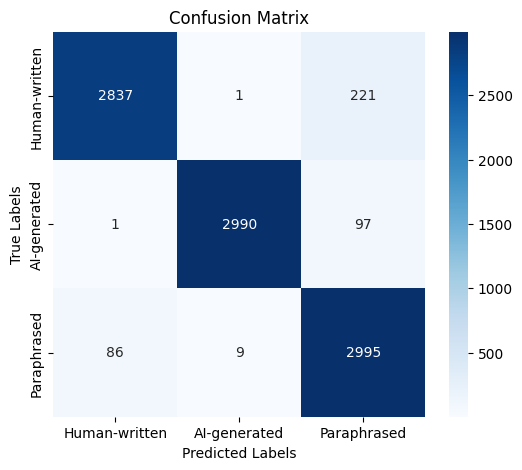

In [45]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


true_labels = []
predicted_labels = []

for idx, row in test_df.iterrows():
    text = row['abstract']
    true_label = row['label']

    logits_list = []
    predictions = []

    for prompt in prompts:
        result, logits = get_prediction_with_threshold(prompt, text)
        predictions.append(result)

    most_common_prediction = max(set(predictions), key=predictions.count)

    # Collect true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(most_common_prediction)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Human-written", "AI-generated", "Paraphrased"]))

print("Accuracy:", accuracy_score(true_labels, predicted_labels))

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human-written', 'AI-generated', 'Paraphrased'], yticklabels=['Human-written', 'AI-generated', 'Paraphrased'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

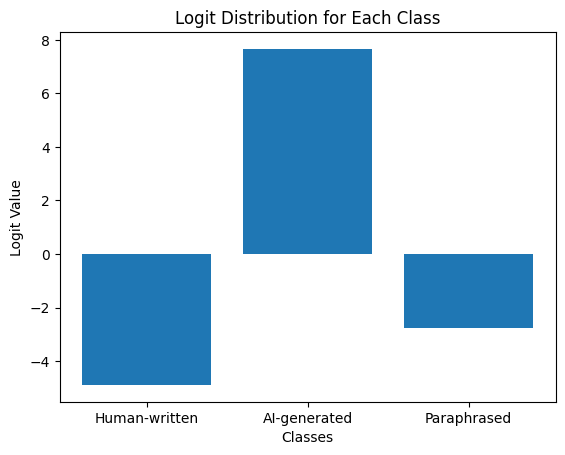

In [60]:
import matplotlib.pyplot as plt

def plot_logits(logits):
    labels = ['Human-written', 'AI-generated', 'Paraphrased']
    logits = logits.squeeze().cpu().numpy()
    plt.bar(labels, logits)
    plt.title('Logit Distribution for Each Class')
    plt.xlabel('Classes')
    plt.ylabel('Logit Value')
    plt.show()

plot_logits(logits)


**Least to Most** ELECTRA

In [49]:
model_path = '/content/drive/MyDrive/DL_project/Electra/trained_model_electra_new_para_data'

In [50]:
print(os.path.exists('/content/drive/MyDrive/DL_project/Electra/trained_model_electra_new_para_data'))

True


In [51]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer

model = ElectraForSequenceClassification.from_pretrained(model_path)

# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained(model_path)


In [53]:
import torch
# Sample text to analyze
text = """

Self Consistency (COT) Goal: The Self Consistency technique is used to enhance the forecast accuracy and dependability of the model. In this method, various outputs are generated for the same input, and the most consistent response among all the created answers is used to determine the final output.
Application: Several outputs are generated for each query in each model, and the most reliable answer is chosen. This method produces more trustworthy outcomes by reducing biases and inconsistencies in the model's predictions.
Direct Prompt Objective: When simple, straightforward responses are required, then direct prompting is used. In this approach, the model is given a very clear and concise instruction to which it is expected to provide a direct response without having to use complex logic or numerous steps.
Application: The models are directly prompted to instantiate responses for immediate answers when the task requires only simple fact retrieval or classification. In this way, the models can focus on generating responses with accuracy and speed where the task at hand does not require reasoning or elaborate instructions.


"""

prompts = [
    "Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.",  # Complex prompt with focus on markers
    "What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.",  # More in-depth feature-based analysis
    "Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.",  # Deeper into patterns and features
    "What are the primary distinctions between human-written, AI-generated, and paraphrased texts? Analyze aspects such as creativity, consistency, structure, and originality. How do these features influence the classification?",  # Detailed comparative analysis
]




In [54]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_prediction(prompt, text):
    # Tokenize input and model prediction
    inputs = tokenizer(prompt + " " + text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()  # Convert logits to predicted class (0, 1, or 2)
    return predicted_class

#Least-to-Most prompting
for prompt in prompts:
    result = get_prediction(prompt, text)
    prediction_label = 'AI-generated' if result == 1 else 'Human-written' if result == 0 else 'Paraphrased'
    print(f"Prompt: {prompt}")
    print(f"Prediction: {prediction_label}")
    print("\n")


Prompt: Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.
Prediction: Paraphrased


Prompt: What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.
Prediction: Paraphrased


Prompt: Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.
Prediction: Paraphrased


Prompt: What are the primary distinctions between human-written, AI-generated, and paraphrased texts? Analyze aspects such as creativity, consistency, structure, and originality. How do these features influence the classification?
Prediction: Paraphrased




In [55]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

logits_list = []  # Initialize an empty list to collect logits
predictions = []  # Initialize an empty list to collect predictions

def get_prediction_with_threshold(prompt, text, threshold=0.5):
    # Tokenize input
    inputs = tokenizer(prompt + " " + text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits

    # Softmax to get probabilities
    probs = torch.softmax(logits, dim=-1)
    max_prob, predicted_class = torch.max(probs, dim=-1)

    # Apply thresholding
    if max_prob < threshold:
        return 2, logits
    return predicted_class.item(), logits

# Iterate through prompts and collect predictions and logits
for prompt in prompts:
    result, logits = get_prediction_with_threshold(prompt, text)
    logits_list.append(logits.squeeze(0))  # Append logits to the list (squeeze to remove batch dimension)
    predictions.append(result)  # Append the predicted class
    prediction_label = 'AI-generated' if result == 1 else 'Human-written' if result == 0 else 'Paraphrased'
    print(f"Prompt: {prompt}")
    print(f"Logits: {logits}")
    print(f"Prediction: {prediction_label}")
    print("\n")



Prompt: Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.
Logits: tensor([[-2.6316, -4.5021,  6.3878]], device='cuda:0')
Prediction: Paraphrased


Prompt: What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.
Logits: tensor([[-2.2846, -4.4451,  5.9743]], device='cuda:0')
Prediction: Paraphrased


Prompt: Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.
Logits: tensor([[-2.5192, -4.4620,  6.2349]], device='cuda:0')
Prediction: Paraphrased


Prompt: What are the primary distinctions between human-written, AI-generated, and paraphrased texts? Analyze aspects such as creativity, consistency, structure, an

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import classification_report
import pandas as pd

df_human = pd.read_csv("human.csv")
df_ai = pd.read_csv("ai.csv")
df_paraphrased = pd.read_csv("paraphrased.csv")

df_human['label'] = 0
df_ai['label'] = 1
df_paraphrased['label'] = 2

# only abstract and label columns are required
df_human = df_human[['abstract', 'label']]
df_ai = df_ai[['abstract', 'label']]
df_paraphrased = df_paraphrased[['abstract', 'label']]

#combining all csv
df = pd.concat([df_human, df_ai, df_paraphrased], ignore_index=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#to check count of each class to ensure it is balanced
print(df['label'].value_counts())

#dataset split into 80% train and 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training Set Size: {len(train_df)}")
print(f"Test Set Size: {len(test_df)}")


# Select 10 random samples from the test dataset
random_test_samples = test_df.sample(n=10, random_state=42)

# Iterate through each row in the random test samples
for idx, row in random_test_samples.iterrows():
    text = row['abstract']  # Extract the abstract (text) from the current row
    true_label = row['label']  # Extract the true label for evaluation

    print(text)
    print(f"Evaluating test example {idx + 1}/{len(random_test_samples)}")
    print(f"True Label: {true_label}")

    logits_list = []  # Collect logits for all prompts for this text
    predictions = []  # Collect predictions for all prompts for this text

    # Iterate through prompts
    for prompt in prompts:
        result, logits = get_prediction_with_threshold(prompt, text)
        logits_list.append(logits.squeeze(0))  # Append logits to the list
        predictions.append(result)  # Append the predicted class
        prediction_label = 'AI-generated' if result == 1 else 'Human-written' if result == 0 else 'Paraphrased'
        print(f"Prompt: {prompt}")
        print(f"Logits: {logits}")
        print(f"Prediction: {prediction_label}")
        print("\n")

    # Aggregate predictions for this text (if needed)
    most_common_prediction = max(set(predictions), key=predictions.count)
    print(f"Most Common Prediction for this example: {most_common_prediction}")
    print("\n" + "="*80 + "\n")


label
1    15395
2    15395
0    15391
Name: count, dtype: int64
Training Set Size: 36944
Test Set Size: 9237
This paper focuses on analyzing the frequency characteristics of the indirect high frequency signal injection method for sensorless starting control of aircraft startergenerator The study investigates the effects of high frequency signal injection on different components of the startergenerator including rotors generators windings and rectifiers Moreover the frequency control mechanism is examined as it plays a critical role in ensuring stable operation of the startergenerator Through simulation and experimental results the paper presents an accurate estimation of the frequency characteristics and their impact on the sensorless starting control of the aircraft startergenerator The findings demonstrate the effectiveness of the indirect high frequency signal injection method in realizing the sensorless starting control of the aircraft startergenerator which has significant implic

Classification Report:
               precision    recall  f1-score   support

Human-written       0.98      0.93      0.95      3059
 AI-generated       1.00      0.99      0.99      3088
  Paraphrased       0.92      0.98      0.95      3090

     accuracy                           0.96      9237
    macro avg       0.96      0.96      0.96      9237
 weighted avg       0.96      0.96      0.96      9237

Accuracy: 0.9631915123957995
Confusion Matrix:
[[2832    0  227]
 [   0 3047   41]
 [  57   15 3018]]


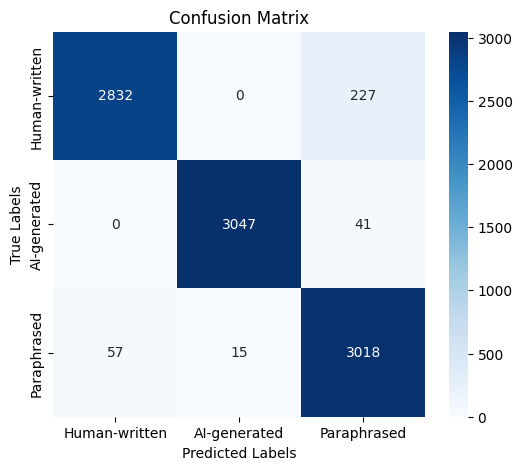

In [57]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


true_labels = []
predicted_labels = []

for idx, row in test_df.iterrows():
    text = row['abstract']
    true_label = row['label']

    logits_list = []
    predictions = []

    for prompt in prompts:
        result, logits = get_prediction_with_threshold(prompt, text)
        predictions.append(result)

    most_common_prediction = max(set(predictions), key=predictions.count)

    # Collect true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(most_common_prediction)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Human-written", "AI-generated", "Paraphrased"]))

print("Accuracy:", accuracy_score(true_labels, predicted_labels))

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human-written', 'AI-generated', 'Paraphrased'], yticklabels=['Human-written', 'AI-generated', 'Paraphrased'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

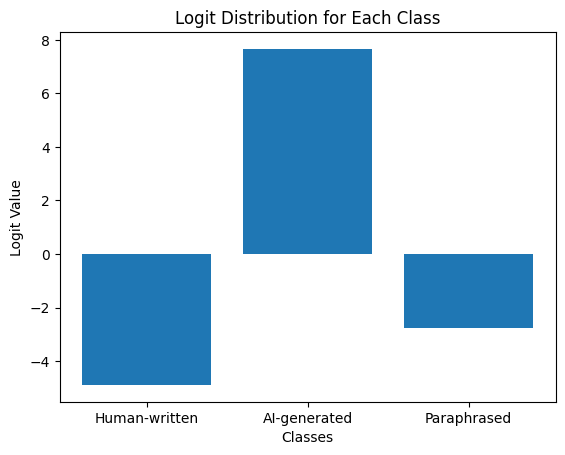

In [59]:
import matplotlib.pyplot as plt

def plot_logits(logits):
    labels = ['Human-written', 'AI-generated', 'Paraphrased']
    logits = logits.squeeze().cpu().numpy()
    plt.bar(labels, logits)
    plt.title('Logit Distribution for Each Class')
    plt.xlabel('Classes')
    plt.ylabel('Logit Value')
    plt.show()

plot_logits(logits)
